[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MobleyLab/drug-computing/blob/master/uci-pharmsci/assignments/MD/MD.ipynb)

# Molecular Dynamics (MD)

## Objective:
Perform some basic molecular dynamics (MD) simulations on a simple polymer model, perform some initial tests, and then after equilibrating the system, compute the self-diffusion coefficient for several different chain lengths. 

__Due date__: As assigned in class

## Overview:
One simple model of a polymer is just a chain of Lennard-Jones atoms. Here we will simulate such chains, interacting according to the potential (in dimensionless form): 

\begin{equation}
U^* = \sum \limits_{i<j \mathrm{,\  ij\  not\  bonded}} 4\left( r_{ij}^{-12} - r_{ij}^{-6}\right) + \sum \limits_{i<j\mathrm{,\  ij\  bonded}} \frac{k}{2} \left( r_{ij} - r_0\right)^2
\end{equation}

(Note that, as in the Energy Minimization assignment, we are using the dimensionless form, so that all of the constants are hidden in the units.)

Here, atoms have Lennard-Jones attractions and repulsions, and bonds between atoms along the polymer chain(s) are represented by simple harmonic springs. There are no torsional or angle potentials, and no electrostatic interactions. However, this simple model does share basic elements with the models we still use today for proteins and small molecules -- specifically, our classical MD models today begin with the potential above and add additional terms.
Simple systems like this polymer model have been thoroughly studied as models of polyatomic molecules, and as models of short polymers. It is relatively easy to derive or determine scaling laws for various physical properties as a function of polymer length in such systems. One such study, by Reis et al., [ Fluid Phase Equilibria 221: 25 (2004) ](https://doi.org/10.1016/j.fluid.2004.04.007) evaluated the self-diffusion coefficient for chains of different lengths. (The self-diffusion coefficient measures diffusive motion of something in a solution consisting of itself, for example the self-diffusion coefficient of water in water describes how mobile a water molecule is in pure water.)
Here, you will use some Python and Fortran libraries to set up some initial test simulations and make a plot relating to equilibration. Following that, you will compute the self-diffusion coefficient as directed below, making contact with the data of Reis et al. 

Most of the functions you will need have already been written for you and are provided here. Most of this assignment will involve using them to conduct a simulation. In addition to the paper mentioned, you will need `mdlib.f90` and `MD_functions.py`. As in the Energy Minimization assignment you did previously, you will need to compile `mdlib.f90` into a .so file suitable for use within Python.  

## Background/settings:
### Introduction of our variables:
Here, the potential energy will be as given above. Again, note that we are working in dimensionless form. 

We will simulate a system with a total of N monomers, some of which will be linked to form polymers. Each polymer will consist of M monomers, so that if $N_{poly}$ is the number of polymers, $N = M\times N_{poly}$. That is to say, we have $N_{poly}$ polymers each consisting of $M$ linked monomers in a chain, for a total of $N$ particles. 

As usual, our system will have a density, $\rho$, which is N/V. We will work with a particular temperature, $T$, and cutoff distance, $R_c$, beyond which Lennard-Jones interactions will not be included. Additionally, we need to specify a bond strength and equilibrium separation, $k$ and $r_0$, respectively. And we will take timesteps $\Delta t$ using the velocity Verlet integrator.

### Settings to use (unless otherwise noted)

Unless otherwise noted, here you should use the following settings:
* $k = 3000$ (spring constant)
* $r_0 = 1$ (preferred bond length)
* $N = 240$ (number of particles)
* $\rho = N/V = 0.8$ so that $L$, the box size, is $(N/\rho)^{1/3}$ 
* Use $L$ as the box size in your code
* $\Delta t = 0.001$ (timestep)
* $T = 1.0$ (temperature)
* $R_c = 2.5$ (call this Cut in your code)

Our use of the dimensionless form here includes setting all particle masses to 1. Because of this, forces and accelerations are the same thing. Additionally, units can be dropped, and the Boltzmann constant is equal to 1 in these units.


### What's provided

In this case, mdlib provides almost the same CalcEnergy and CalcEnergyForces routines you used in the previous assignment (for energy minimizations). Additionally, it provides a VVIntegrate function to actually use the integrator (Velocity Verlet) to take a timestep. You should look through the Fortran code to make sure you understand what is being done and see how it connects to what we covered in lecture.

The Python syntax for using VVintegrate looks like: 

`Pos, Vel, Accel, KEnergy, PEnergy = mdlib.vvintegrate( Pos, Vel, Accel, M, L, Cut, dt )` 

This takes a single timestep (covering time dt) and returns the position, velocity, acceleration, kinetic energy, and potential energy. 

Likewise, mdlib provides functions for calculating the potential energy, or the potential energy and forces, as:
`PEnergy = mdlib.calcenergy(Pos, M, L, Cut)`
and
`PE, Forces = mdlib.calcenergyforces(Pos, M, L, Cut, Forces)` 

By way of additional background/tips, Scott Shell has some very useful [simulation best practices](https://sites.engineering.ucsb.edu/~shell/che210d/Simulation_best_practices.pdf) tips which can help with thinking through how to code up and conduct effective simulations.

## Your assignment
All, or almost all, of the functions you will need to complete this assignment are described below. But before getting to the description, I want to explain the assignment. 

### Part A: Develop a simple molecular dynamics code and examine potential energy versus time for several values of M 
Edit the supplied code below (or MD.py if you prefer to work with the plain text; note that I have also provided MD_functions.py which is utilized by this notebook which provides only the functions you need and not a template for the code you need to write, since this is below) to develop a simple molecular dynamics code. Most of the functions you need are already provided (see documentation below, or in MD_functions.py). But, you do need to fill in the core of two functions:

* InitVelocities(N,T): Should take N, a number of particles and a target temperature and return a velocity array (‘Vel’) which is Nx3 with mean velocity corresponding to the correct average temperature. You may wish to do this by assigning random velocities and rescaling (see below).

* RescaleVelocities(Vel, T): Re-center the velocities to zero net momentum to remove any overall translational motion (i.e., subtract off the average velocity from all particles) and then re-scale the velocities to maintain the correct temperature. This can be done by noting that the average kinetic energy of the system is related in a simple way to the effective temperature: 

\begin{equation}
\frac{1}{2}\sum \limits_i m_i v_i^2 = \frac{3}{2} N k_B T
\end{equation}

The left-hand term is the kinetic energy, and here can be simplified by noting all of the masses in the system are defined to be 1. The right hand term involves the Boltzmann constant, the number of particles in the system, and the instantaneous temperature.

So, you can compute the effective temperature of your system, and translate this into a scaling factor which you can use to multiply (scale) all velocities in the system to ensure you get the correct average temperature (see https://www.compchems.com/thermostats-in-molecular-dynamics/#velocity-rescaling). **Specifically, following the page above, compute a (scalar) constant $\lambda$ by which you will multiply all of the velocities to ensure that the effective temperature is at the correct target value after rescaling.** To do this calculation you will need to compute the kinetic energy, which involves the sum above. 
    
Remove translational motion, rescale the velocities, and have your function return the  updated velocity array.
Once the above two functions are written, finishing write a simple MD code using the available functions to:
* Initially place atoms on a cubic lattice with the correct box size
* Energy-minimize the initial configuration using the conjugate-gradient energy minimizer; this will help ensure the simulation doesn’t “explode” (a highly technical term meaning “crash”) when you begin MD
* Assign initial velocities and compute forces (accelerations)
* Use the velocity Verlet integrator to perform a molecular dynamics run. Rescale atomic velocities every **RescaleFreq** integration steps to achieve the target temperature T. ( You can test whether you should rescale the velocities using the modulo (remainder) operator, for example $i % RescaleFreq == 0$)
   * You might want to use RescaleFreq = 100 (for extra credit, you can try several values of RescaleFreq and explain the differences in fluctuations in the potential energy versus time that you see)

Use the settings given above for $N$, $\rho$, $T$, the timestep, and the cutoff distance. 

Perform simulations for $M = 2, 4, 6, 8, 12,$ and $16$ and store the total energies (kinetic plus potential) versus time out to 2,000 timesteps. (Remember, $M$ controls the number of particles per polymer; you are keeping the same total number of particles in the system and changing the size of the polymers). On a single graph, plot the potential energy versus time for each of these cases (each in a different color). Turn in this graph.  

Note also you can visualize, if desired, using the Python module for writing to PDB files which you saw in the Energy Minimization exercise. 


### Part B: Extend your code to compute the self-diffusion coefficient as a function of chain length

Modify your MD code from above to perform a series of steps that will allow you to compute the self-diffusion coefficient as a function of chain length and determine how diffusion of polymers depends on the size of the polymer. To compute the self-diffusion coefficient, you will simply need to monitor the motion of each polymer in time. 

Here, you will first perform two equilibrations at constant temperature using velocity rescaling . The first will allow the system to reach the desired temperature and forget about its initial configuration (remember, it was started on a lattice). The second will allow you to compute the average total energy (kinetic plus potential) of the system. Then, you will fix the total energy at this value and perform a production simulation. 

Here’s what you should do:
* Following initial preparation (like above), first perform equilibration for NStepsEquil1 using velocity rescaling to target temperature T every RescaleFreq steps, using whatever value of RescaleFreq you used previously (NOT every step!)
* Perform a second equilibration for `NStepsEquil2` timesteps using velocity rescaling at the same frequency, storing energies (kinetic and potential, separately) while you do this. 
* Compute the average total energy (kinetic plus potential) over this second equilibration and rescale the velocities to start the final phase with the correct total energy. In other words, the total energy at the end of equilibration will be slightly above or below the average; you should find the kinetic energy you need to have to get the correct total energy, and rescale the velocities to get this kinetic energy. After this you will be doing no more velocity rescaling. (Hint: You can do this final rescaling easily by computing a scaling factor, and you will probably not be using the rescaling code you use to maintain the temperature during equilibration.)
* Copy the initial positions of the particles into a reference array for computing the mean squared displacement, for example using `Pos0 = Pos.copy()`
* Perform a production run for `NStepsProd` integration steps with constant energy (NVE) rather than velocity rescaling. Periodically record the time and mean squared displacement of the atoms from their initial positions. (You will need to write a small bit of code to compute mean squared displacements, but it shouldn’t take more than a couple of lines; you may send it to me to check if you are concerned about it). The mean squared displacement is given by 
\begin{equation}
\left<\left| \mathbf{r}-\mathbf{r_0} \right|^2 \right>
\end{equation}

  where the $\mathbf{r}$'s are the current and initial positions of the object in question so the mean squared   
  displacement measures the square of the distance traveled for the object. 

* Compute the self-diffusion coefficient, $D$. The mean squared displacement relates to the self-diffusion coefficient, $D$, in this way:
\begin{equation}
\left< \left| \mathbf{r} - \mathbf{r_0}\right| \right>^2 = 6 D t
\end{equation}

Here $D$ is the self-diffusion coefficient and t is the elapsed time. That is, the expected squared distance traveled (mean squared displacement) grows linearly with the elapsed time.

For settings, use NStepsEquil1 = 10,000 = NStepsEquil2 and NStepsProd = 100,000. (Note: You should probably do a “dry run” first with shorter simulations to ensure everything is working, as 100,000 steps might take an hour or more to run).

* Perform these runs for $M = 2, 4, 6, 8, 12,$ and $16$, storing results for each. 
* Plot the mean-squared displacement versus time for each M on the same graph. 
* Compute the diffusion coefficient for each $M$ from the slope of each graph and plot these fits on the same graph. You can do a linear least-squares fit easily in Numpy. 

`Slope, Intercept = np.polyfit( xvals, yvals, 1)`

Plot the diffusion coefficient versus $M$ and try and see if it follows any obvious scaling law. It should decrease with increasing $M$, but with what power? (You may want to refer to the Reis et al. paper). 

### What to turn in:
* Your plot of the potential energy versus time for each $M$ in Part A
* Mean-squared displacement versus time, and fit, for each $M$ in Part B, all on one plot
* The diffusion coefficient versus $M$ in Part B
* Your code for at least Part B
* Any comments you have - do you think you got it right? Why or why not? What was confusing/helpful? What would you do if you had more time? 
* Clearly label axes and curves on your plots!

You can send your comments/discussion as an e-mail, and the rest of the items as attachments.

### What’s provided for you: 
In this case, most of what you need is provided in the importable module `MD_functions.py` (which you can view with your favorite text editor, like `vi` or Atom), except for the functions for initial velocities and velocity rescaling -- in those cases, the shells are present below and you need to write the core (which will be very brief!).  **However, you will also need to insert the code for the `ConjugateGradient` function in `MD_functions.py`**. This is similar to (but not identical to) the ConjugateGradient code from the energy minimization assignment -- specifically, now our particles are joined into polymers, meaning that the function needs slightly different arguments to pass to energy and force evaluation routines. 

From the Fortran library `mdlib` (which you will compile as usual via `f2py3 -c -m mdlib mdlib.f90` or similar), the only new function you need is Velocity Verlet. In `MD_functions.py`, the following tools are available (this shows their documentation, not the details of the code, but you should only need to read the documentation in order to be able to use them. NOTE: No modification of these functions is needed; you only need to use them. You will only need to write `InitVelocities` and `RescaleVelocities` as described above, plus provide your previous code for `ConjugateGradient`: 


## Installing Packages

***If you are running this on Google Colab, please add the installation blocks from the [getting started notebook](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/Getting_Started.ipynb) or [condacolab](https://github.com/aakankschit/drug-computing/blob/master/uci-pharmsci/Getting_Started_condacolab.ipynb) here and then execute the code below***


Help on module MD:

NAME

    MD - #MD exercise template for PharmSci 175/275


FUNCTIONS

FUNCTIONS
    
    ConjugateGradient(Pos, dx, EFracTolLS, EFracTolCG, M, L, Cut)
        Performs a conjugate gradient search.
        Input:
            Pos: starting positions, (N,3) array
            dx: initial step amount
            EFracTolLS: fractional energy tolerance for line search
            EFracTolCG: fractional energy tolerance for conjugate gradient
            M: Monomers per polymer
            L: Box size
            Cut: Cutoff
        Output:
            PEnergy: value of potential energy at minimum
            Pos: minimum energy (N,3) position array

    InitPositions(N, L)
        Returns an array of initial positions of each atom,
        placed on a cubic lattice for convenience.
        Input:
            N: number of atoms
            L: box length
        Output:
            Pos: (N,3) array of positions

    InitVelocities(N, T)
        Returns an initial random velocity set.
        Input:
            N: number of atoms
            T: target temperature
        Output:
            Vel: (N,3) array of atomic velocities

        InstTemp(Vel)
        Returns the instantaneous temperature.
        Input:
            Vel: (N,3) array of atomic velocities
        Output:
            Tinst: float
    
    InstTemp(Vel):
       Returns the instantaneous temperature.
       Input:
           Vel: (N,3) array of atomic velocities
       Output:
           Tinst: float

    RescaleVelocities(Vel, T)
        Rescales velocities in the system to the target temperature.
        Input:
            Vel: (N,3) array of atomic velocities
            T: target temperature
        Output:
            Vel: same as above 
            
    LineSearch(Pos, Dir, dx, EFracTol, M, L, Cut, Accel=1.5, MaxInc=10.0,  
               MaxIter=10000)
        Performs a line search along direction Dir.
        Input:
            Pos: starting positions, (N,3) array
            Dir: (N,3) array of gradient direction
            dx: initial step amount
            EFracTol: fractional energy tolerance
            M: Monomers per polymer
            L: Box size
            Cut: Cutoff
            Accel: acceleration factor
            MaxInc: the maximum increase in energy for bracketing
            MaxIter: maximum number of iteration steps
        Output:
            PEnergy: value of potential energy at minimum along Dir
            Pos: minimum energy (N,3) position array along Dir



## Here, you should actually write your functions:

In [2]:
import mdlib 
from MD_functions import *
import numpy as np 


def InitVelocities(N, T):
    """Returns an initial random velocity set.
Input:
    N: number of atoms
    T: target temperature
Output:
    Vel: (N,3) array of atomic velocities
"""
    #WRITE THIS CODE
    init_velocities = np.random.randn(N, 3)
    Vel = RescaleVelocities(init_velocities, T)
    #THEN RETURN THE NEW VELOCITIES
    return Vel


def RescaleVelocities(Vel, T):
    """Rescales velocities in the system to the target temperature.
Input:
    Vel: (N,3) numpy array of atomic velocities
    T: target temperature
Output:
    Vel: same as above
"""
    #WRITE THIS CODE
    N = Vel.shape[0]
    #recenter to zero net momentum (assuming all masses same)
    # need to compute the center-of-mass velcoits for each x,y,z
    # returns a (1,3) array representing the average velocity in each direction.
    V_center_of_mass = np.mean(Vel, axis=0)
    
    Vel = Vel - V_center_of_mass
    
    #find the total kinetic energy
    KE = 0.5 * np.sum(Vel**2)
    #find velocity scale factor from ratios of kinetic energy
    T_current = (2/3) * (KE / N)
    
    scale_factor = np.sqrt(T/T_current)
    #Update velocities
    Vel = Vel*scale_factor

    #NOW RETURN THE NEW VELOCITIES
    return Vel

## Now use your functions, coupled with those provided, to code up your assignment:

In [3]:
#PART A:

# #Define box size and other settings
# k=3000 
# r0=1 
# N=240 
# rho=0.8 #Solve to find L
# density = N/V (box is cubic L^3)
# #Set L
# dt=0.001 
# T=1.0 
# Cut=2.5
# RescaleFreq = 100 #See note above - may want to try several values

def MD_algorithm(M, MD_steps, N=240, rho=0.8, dt=0.001, T=1.0, cut=2.5, RescaleFreq=100,  EFracTolCG=1.0e-10, EFracTolLS=1.0e-8, init_prep=False):
    """
    Performs a conjugateGradient following a molecular dynamics (MD) simulation using the velocity Verlet integration method.

    This function first runs an minimization following a MD simulation with  velocity rescaling for equilibration.

    Parameters
    ----------
    M : int
        Number of monomers per polymer chain.
    MD_steps : int
        Number of MD integration steps to perform.
    N : int, optional
        Total number of particles, by default 240.
    rho: float 
        Density of given box 
    dt : float, optional
        Time step for integration, by default 0.001.
    T : float, optional
        Target temperature for velocity rescaling, by default 1.0.
    cut : float, optional
        Cutoff distance for interactions, by default 2.5.
    RescaleFreq : int, optional
        Frequency (in steps) at which velocity rescaling is applied, by default 100.
    EFracTolCG: float 
        Fraction of tolerance for gradient decent 
    EFracTolLS: float 
        Fraction of tolerance lower limit 
    init_prep: bool 
        Whether to return parameters or a dictionary 
    Returns
    -------
    results : dict
        A dictionary containing:
        - 'KE' : list of float
            Kinetic energy values at each step.
        - 'PE' : list of float
            Potential energy values at each step.
        - 'step' : list of int
            List of time steps.
        - 'MSD' : list of float
            Mean squared displacement values at each step.
    positions: ndarray, shape (N, 3)
        Final Particle position 
    velocities : ndarray, shape (N, 3)
        Final velocities after the simulation.
    Forces : ndarray, shape (N, 3)
        Final forces after the simulation.
    """
    
    # store results 
    results = {
        'KE':[],
        'PE':[],
        'step':[],
        'positions':[],
    }
    
    #Initially place atoms on a cubic lattice 
    L = (N/rho)**(1/3)
    positions = InitPositions(N, L)
    # number of dimensions  
    ndim = positions.shape[1]
    #Energy-minimize the initial configuration using the conjugate-gradient energy minimizer
    PE, positions = ConjugateGradient(positions, dx=dt, EFracTolCG=EFracTolCG,EFracTolLS=EFracTolLS, M=M, L=L, Cut=cut)
    #Assign initial velocities and compute forces (accelerations)
    velocities = InitVelocities(N, T)
    # initialized forces
    Forces = np.zeros_like(positions)  
    # compute initial forces
    PE, Forces = mdlib.calcenergyforces(positions, M, L, cut, Forces, ndim, N)

    #Use the velocity Verlet integrator to perform a molecular dynamics run, rescaling velocities when appropriate
    # compute KE
    KE = 0.5 * np.sum(velocities**2)
    # perform MD run 
    for step in range(MD_steps):
        # rescale velocities at every RescaleFreq step?
        if step % RescaleFreq == 0:
            velocities = RescaleVelocities(velocities, T)
        
        # Velocity Verlet integration step 
        positions, velocities, Forces, KE, PE = mdlib.vvintegrate(positions, velocities, Forces, M, L, cut, dt, ndim, N)
        # store energies 
        results['KE'].append(KE)
        results['PE'].append(PE)
        results['step'].append(step)
        results['positions'].append(np.copy(positions))
        # print(f"Step {step}: Forces (first 5) = {Forces[:5]}")
        #print(f"Step {step}: Positions (first 5) = {positions[:5]}")

    if init_prep:
        return positions, velocities, Forces, L 
    
    return results



#Define your M value(s)
M = [2,4,6,8,12,16]



linked_monomers = [MD_algorithm(M=m, MD_steps=2000) for m in M]

In [4]:
print(mdlib.vvintegrate.__doc__)


pos,vel,accel,kenergy,penergy = vvintegrate(pos,vel,accel,m,l,rc,dt,[dim,natom])

Wrapper for ``vvintegrate``.

Parameters
----------
pos :  rank-2 array('d') with bounds (natom,dim)
vel :  rank-2 array('d') with bounds (natom,dim)
accel :  rank-2 array('d') with bounds (natom,dim)
m : input int
l : input float
rc : input float
dt : input float

Other Parameters
----------------
dim : input int, optional
    Default: shape(pos, 1)
natom : input int, optional
    Default: shape(pos, 0)

Returns
-------
pos : rank-2 array('d') with bounds (natom,dim)
vel : rank-2 array('d') with bounds (natom,dim)
accel : rank-2 array('d') with bounds (natom,dim)
kenergy : float
penergy : float



In [5]:
print(mdlib.calcenergyforces.__doc__)

penergy,forces = calcenergyforces(pos,m,l,rc,forces,[dim,natom])

Wrapper for ``calcenergyforces``.

Parameters
----------
pos : input rank-2 array('d') with bounds (natom,dim)
m : input int
l : input float
rc : input float
forces :  rank-2 array('d') with bounds (natom,dim)

Other Parameters
----------------
dim : input int, optional
    Default: shape(pos, 1)
natom : input int, optional
    Default: shape(pos, 0)

Returns
-------
penergy : float
forces : rank-2 array('d') with bounds (natom,dim)



In [6]:
mdlib.calcenergyforces

<fortran function calcenergyforces>

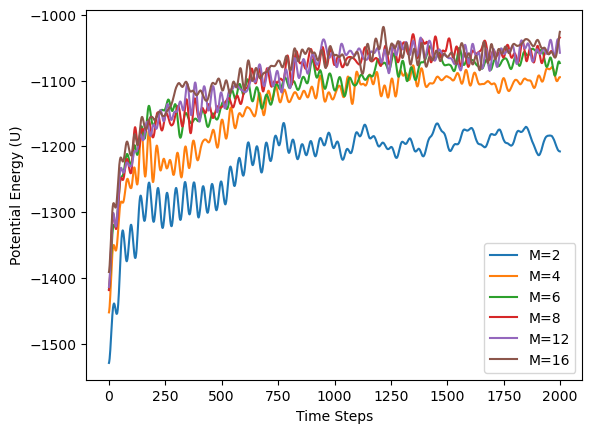

In [7]:
import matplotlib.pyplot as plt

for index, linked_monomer in enumerate(linked_monomers):
    
    plt.plot(linked_monomer['step'], linked_monomer['PE'], label=f'M={M[index]}')

plt.ylabel('Potential Energy (U)')
plt.xlabel('Time Steps')
plt.legend()
plt.show()


In [10]:
def md_run(M, MD_steps, L, positions, velocities, Forces, 
           N=240, dt=0.001, T=1.0, cut=2.5, RescaleFreq=100, NVE=False):
    """
    Performs a molecular dynamics (MD) simulation using the velocity Verlet integration method.

    This function runs an MD simulation with optional velocity rescaling for equilibration 
    and computes the mean squared displacement (MSD) during the production run.

    Parameters
    ----------
    M : int
        Number of monomers per polymer chain.
    MD_steps : int
        Number of MD integration steps to perform.
    L : float
        Box length for periodic boundary conditions.
    positions : ndarray, shape (N, 3)
        Initial positions of particles.
    velocities : ndarray, shape (N, 3)
        Initial velocities of particles.
    Forces : ndarray, shape (N, 3)
        Initial forces acting on particles.
    N : int, optional
        Total number of particles, by default 240.
    dt : float, optional
        Time step for integration, by default 0.001.
    T : float, optional
        Target temperature for velocity rescaling, by default 1.0.
    cut : float, optional
        Cutoff distance for interactions, by default 2.5.
    RescaleFreq : int, optional
        Frequency (in steps) at which velocity rescaling is applied, by default 100.
    NVE : bool, optional
        If True, the simulation runs in NVE ensemble (no velocity rescaling), by default False.

    Returns
    -------
    results : dict
        A dictionary containing:
        - 'KE' : list of float
            Kinetic energy values at each step.
        - 'PE' : list of float
            Potential energy values at each step.
        - 'step' : list of int
            List of time steps.
        - 'positions' : list of ndarray
            List of particle positions at each step.
        - 'MSD' : list of float
            Mean squared displacement values at each step.
    velocities : ndarray, shape (N, 3)
        Final velocities after the simulation.
    Forces : ndarray, shape (N, 3)
        Final forces after the simulation.

    Notes
    -----
    - If `NVE` is set to `True`, velocity rescaling is **disabled**, ensuring energy conservation.
    - The MSD is computed with respect to the initial positions at the start of the function.
    - The velocity Verlet algorithm is used for integration, updating positions, velocities, and forces.

    Examples
    --------
    Run an MD simulation with `M = 4` and `5000` steps:

    >>> results, final_vel, final_forces = md_run(M=4, MD_steps=5000, L=10.0,
    ...                                           positions=init_positions, velocities=init_velocities,
    ...                                           Forces=init_forces, dt=0.001, RescaleFreq=200)
    >>> print("Final KE:", results["KE"][-1])
    >>> print("Mean squared displacement:", results["MSD"][-1])
    """
    
    results = {
        'KE': [],
        'PE': [],
        'step': [],
        'positions': [],
        'MSD': [],
    }
    
    ndim = 3  # Number of dimensions
    reference_position = np.copy(positions)  # Store initial positions for MSD calculation
    
    for step in range(MD_steps):
        # Rescale velocities if not in NVE ensemble
        if not NVE and step % RescaleFreq == 0:
            velocities[:] = RescaleVelocities(velocities, T)
        
        # Perform Velocity Verlet integration step
        positions, velocities, Forces, KE, PE = mdlib.vvintegrate(
            positions, velocities, Forces, M, L, cut, dt, ndim, N
        )
        
        # Compute mean squared displacement (MSD)
        MSD = np.mean(np.sum((positions - reference_position) ** 2, axis=1))
        
        # Store results
        results['KE'].append(KE)
        results['PE'].append(PE)
        results['step'].append(step)
        results['positions'].append(np.copy(positions))
        results['MSD'].append(MSD)

    return results, positions, velocities, Forces


In [11]:
#PART B:
#Additionally:
NStepsEquil1 = 10000
NStepsEquil2 = 10000
NStepsProd = 100000
dt = 0.001

RescaleFreqs = [100, 500, 1000, 2000]

#Set up as in A
#Equilibrate for NStepsEquil1 with velocity rescaling every RescaleFreq steps, discarding energies

diffusion_per_RescaleFreq = {}
# this will take about 10mins on M3 pro
for RescaleFreq in RescaleFreqs:
    diffusion_results = {}
    for M in [2, 4, 6, 8, 12, 16]:
        
        equil1_positions, equil1_velocities, equil1_Forces, equil1_L = MD_algorithm(M=M, MD_steps=NStepsEquil1, init_prep=True, dt=dt, RescaleFreq=RescaleFreq)


        #Equilibrate for NStepsEquil2 with velocity rescaling, storing energies
        energies, final_position, velocities, Forces = md_run(M=M, MD_steps=NStepsEquil2, L=equil1_L, positions=equil1_positions, velocities=equil1_velocities, Forces=equil1_Forces, dt=dt, RescaleFreq=RescaleFreq)
        #Stop and average the toal energy. Rescale the velocities so the current (end-of-equilibration) total energy matches the average total energy.
        total_energy_average = (np.sum(energies['KE']) + np.sum(energies["PE"]))/NStepsEquil2
        # get the final total energies 
        total_energy_final = energies['KE'][-1] + energies['PE'][-1]
        # perform a scaling with the energies   
        scale_factor = np.sqrt((total_energy_average - energies['PE'][-1]) / energies['KE'][-1])
        velocities *= scale_factor  

        #Store the particle positions so you can later compute the mean squared displacement
        Pos0 = final_position.copy() 
        Pos0 = np.array(Pos0)


        #Run for NStepsProd at constant energy (NVE) recording time and mean squared displacement periodically
        energies_nve, final_position_nve, velocities_nve, Forces_nve = md_run(M=M, MD_steps=NStepsProd, L=equil1_L, positions=Pos0, velocities=velocities, Forces=Forces, NVE=True, dt=dt, RescaleFreq=RescaleFreq)
        #Compute diffusion coefficient for each M using a fit to the mean squared displacement

        # Convert steps to physical time
        time_vals = np.array(energies_nve['step']) * dt  

        # Ignore first 10% to ensure the samples are independent 
        #start_fit = int(0.1 * len(time_vals)) 
        #Plot mean squared displacement for each M
        #slope, intercept = np.polyfit(time_vals[start_fit:], energies_nve['MSD'][start_fit:], 1)
        slope, intercept = np.polyfit(time_vals, energies_nve['MSD'], 1)

        D = slope / 6  
        diffusion_results[M] = D
    #Plot diffusion coefficient as a function of M
    print(f'Completed RescaleFreq={RescaleFreq}')
    diffusion_per_RescaleFreq[RescaleFreq] = diffusion_results
    

Completed RescaleFreq=100
Completed RescaleFreq=500
Completed RescaleFreq=1000
Completed RescaleFreq=2000


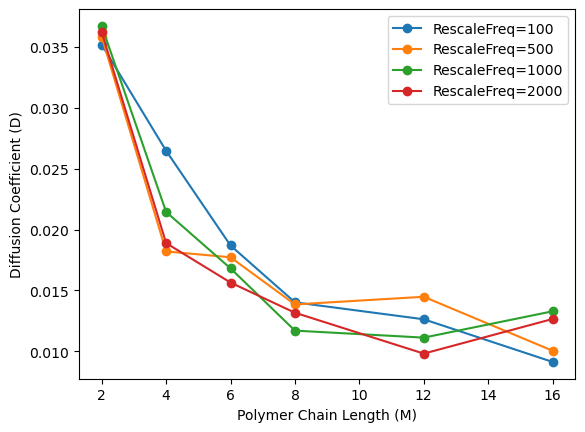

In [53]:
import matplotlib.pyplot as plt

for rescale_freq in diffusion_per_RescaleFreq:
    
    M_vals = np.array(list(diffusion_per_RescaleFreq[rescale_freq].keys()))
    D_vals = np.array(list(diffusion_per_RescaleFreq[rescale_freq].values()))

    plt.plot(M_vals, D_vals, 'o-', label=f"RescaleFreq={rescale_freq}")
    plt.xlabel("Polymer Chain Length (M)")
    plt.ylabel("Diffusion Coefficient (D)")
# plt.xscale('log')  # Optional: Log scale for better visualization
# plt.yscale('log')
plt.legend()
plt.show()

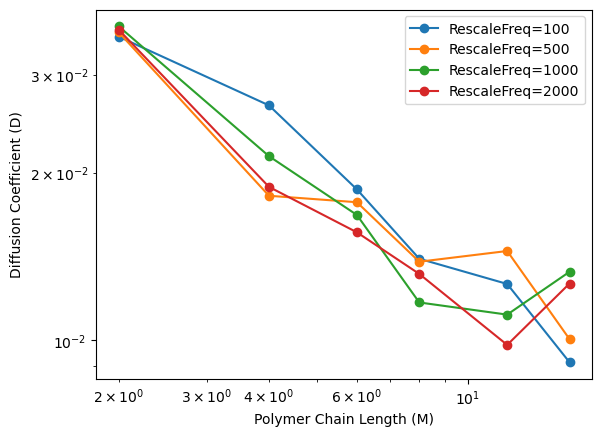

In [54]:
import matplotlib.pyplot as plt

for rescale_freq in diffusion_per_RescaleFreq:
    
    M_vals = np.array(list(diffusion_per_RescaleFreq[rescale_freq].keys()))
    D_vals = np.array(list(diffusion_per_RescaleFreq[rescale_freq].values()))

    plt.plot(M_vals, D_vals, 'o-', label=f"RescaleFreq={rescale_freq}")
    plt.xlabel("Polymer Chain Length (M)")
    plt.ylabel("Diffusion Coefficient (D)")
    # Log scale for better visualization
plt.xscale('log')  
plt.yscale('log')
plt.legend()
plt.show()

In [49]:
diffusion_per_RescaleFreq

{100: {2: np.float64(0.035178699433409226),
  4: np.float64(0.026461760645852688),
  6: np.float64(0.018688450241062415),
  8: np.float64(0.01402379363813193),
  12: np.float64(0.01263288106732133),
  16: np.float64(0.009133229405442374)},
 500: {2: np.float64(0.03582358088021121),
  4: np.float64(0.018201767508759886),
  6: np.float64(0.017721204589136934),
  8: np.float64(0.013851725904624287),
  12: np.float64(0.014480266009058931),
  16: np.float64(0.010050229836109136)},
 1000: {2: np.float64(0.03670842635795858),
  4: np.float64(0.021443295032924303),
  6: np.float64(0.01681020751509024),
  8: np.float64(0.011702216580240787),
  12: np.float64(0.011127095621120494),
  16: np.float64(0.013287677573289552)},
 2000: {2: np.float64(0.0362085096314143),
  4: np.float64(0.018882985146334363),
  6: np.float64(0.01564598685431286),
  8: np.float64(0.013169937339359032),
  12: np.float64(0.009815823149806141),
  16: np.float64(0.012657523592377063)}}

## Follow-up: 
The thermostat used here is not in general recommended, for reasons we will discuss in class. To understand one such reason, please read the “flying ice cube” paper referenced here: J Comp Chem 19:726-740 (1998) <http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1096-987X(199805)19:7%3C726::AID-JCC4%3E3.0.CO;2-S/full>